In [18]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this project, I own a digital music library (pretend) and I need to decide which new artists and albums to purchase for my store. I will be using SQL queries integrated with Python to analyze and visualize the data.

My first steps are to define functions that will integrate SQL with Python. These will help me run my upcoming queries faster.

In [19]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [20]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)

In [21]:
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view')"
    return run_query(q)

In [22]:
print(show_tables())

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table
11   top_countries   view
12             top   view
13           top_c   view
14       top_count   view
15    topcountries   view


Part I - New artist selection.

I need to decide which three, out of four, artists to purchase for my music library:

  
Regal - Hip-Hop

Red Tone - Punk

Meteor and the Girls - Pop

Slim Jim Bites - Blues


I will write a query to discover which genres sell the most tracks in the USA, then create a visualization of that data with Python. I will choose three albums to purchase for my store based the best-selling genres.

In [23]:
q = "SELECT * FROM genre"
genres = run_query(q)
print(genres)

    genre_id                name
0          1                Rock
1          2                Jazz
2          3               Metal
3          4  Alternative & Punk
4          5       Rock And Roll
5          6               Blues
6          7               Latin
7          8              Reggae
8          9                 Pop
9         10          Soundtrack
10        11          Bossa Nova
11        12      Easy Listening
12        13         Heavy Metal
13        14            R&B/Soul
14        15   Electronica/Dance
15        16               World
16        17         Hip Hop/Rap
17        18     Science Fiction
18        19            TV Shows
19        20    Sci Fi & Fantasy
20        21               Drama
21        22              Comedy
22        23         Alternative
23        24           Classical
24        25               Opera


In [24]:
q = '''
    WITH usa_tracks_sold AS
    (
    SELECT i.*
    FROM invoice_line i
    INNER JOIN invoice iv ON i.invoice_id = iv.invoice_id
    WHERE iv.billing_country = 'USA'
    )
    
    SELECT 
        g.name genre, 
        COUNT(uts.invoice_line_id) quantity_sold,
        CAST(COUNT(uts.invoice_line_id) AS float) / 
        (SELECT COUNT(*) FROM usa_tracks_sold) * 100 percentage_sold
    FROM usa_tracks_sold uts
    INNER JOIN track t ON uts.track_id = t.track_id 
    INNER JOIN genre g ON t.genre_id = g.genre_id 
    GROUP BY 1 ORDER BY 2 desc
    LIMIT 10;
'''

top_genres = run_query(q)
print(top_genres)

                genre  quantity_sold  percentage_sold
0                Rock            561        53.377735
1  Alternative & Punk            130        12.369172
2               Metal            124        11.798287
3            R&B/Soul             53         5.042816
4               Blues             36         3.425309
5         Alternative             35         3.330162
6               Latin             22         2.093245
7                 Pop             22         2.093245
8         Hip Hop/Rap             20         1.902950
9                Jazz             14         1.332065


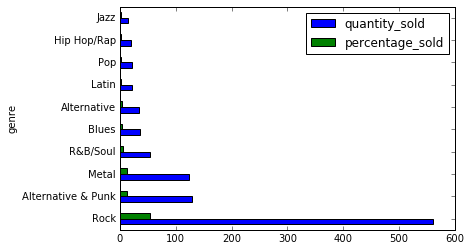

In [25]:
top_genres.plot.barh(x='genre')

This graph represents the top ten genres sold in the USA from my store in both total quantity sold and percentages.

Based on this data, I will choose the Punk band (Red Tone), Blues band (Slim Jim Bites), and Pop band (Meteor and Girls) to purchase for my store. 

I am passing on the hip-hop group, but hip-hop is very close behind pop in popularity in the USA. However, one could still make the case for selecting the hip-hop group if trends anticipate that hip-hop will surpass one of the other genres in the future.

Part II - Sales Per Support Rep

Next I will be analyzing the sales of our support reps and looking for any correlations. I will write an SQL query that concatenates columns and joins tables to gather the data that I need.

In [26]:
support_reps = '''
SELECT 
    e.first_name || " " || e.last_name employee_name,
    SUM(i.total) sales,
    COUNT(c.customer_id) total_customers,
    e.hire_date,
    c.city,
    c.state
FROM employee e
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY 1 ORDER BY 2 desc;
'''

sales_reps = run_query(support_reps)
print(sales_reps)

   employee_name    sales  total_customers            hire_date  \
0   Jane Peacock  1731.51              212  2017-04-01 00:00:00   
1  Margaret Park  1584.00              214  2017-05-03 00:00:00   
2  Steve Johnson  1393.92              188  2017-10-17 00:00:00   

            city state  
0         London  None  
1  Mountain View    CA  
2       Edmonton    AB  


Here we can see the total sales of each support rep. One possible interpretation of the data is that the hire date correlates with higher sales, as the more senior reps have more sales than the junior reps. It makes sense that an employee who worked at a company longer would have had more time to to accumulate sales than a newer employee.

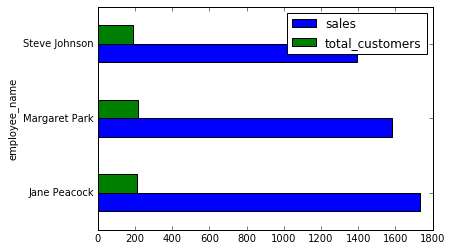

In [27]:
sales_reps.set_index(["employee_name"], inplace=True)
sales_reps.plot(kind='barh')
plt.xlabel("")
plt.show()

This bar chart compares total customers with the total sales of each agent. Total customers per agent, however, remains fairly even across all three agents and, thus, probably does not contribute to more sales. The newest agent, Steve Johnson, has the least amount of both customers and sales. 

Total customers assigned does not appear to correlate with higher sales, although the more senior support reps probably have customers assigned that have been with them longer, resulting in more sales for the support rep over time. 

For now, the data supports my assumption that time with the company is the dominant contributer to higher sales per rep.

Part III - Sales Per Country

I have been directed to calculate data, for each country, on the:

1. total number of customers

2. total value of sales

3. average value of sales per customer

4. average order value

Since many countries only have one customer, I will group all of these into one category of "Other", using the CASE statement in SQL and making sure the "Other" category stay at the bottom of the table.

In [28]:
q = '''

WITH top_countries AS
(
SELECT
    CASE
        WHEN (
            SELECT count(*)
            FROM customer
            WHERE country = c.country
            ) = 1 THEN "Other"
        ELSE c.country
    END AS country,
    COUNT(distinct c.customer_id) total_customers,
    SUM(il.unit_price) total_sales,
    COUNT(DISTINCT iL.invoice_id) total_invoices,
    COUNT(il.track_id) tracks_purchased
FROM customer c
INNER JOIN invoice i on c.customer_id = i.customer_id
INNER JOIN invoice_line il on i.invoice_id = il.invoice_id
GROUP BY 1 ORDER BY 2 desc
)

SELECT 
    country,
    total_customers,
    total_sales,
    (total_sales / total_customers) avg_sales_per_customer,
    (total_sales / total_invoices) avg_invoice_amnt,
    CASE
            WHEN country = "Other" THEN 1
            ELSE 0
    END AS sort
FROM top_countries
GROUP BY country
ORDER BY sort asc, total_sales desc

'''
top = run_query(q)
print(top.loc[:,'country':'avg_invoice_amnt'])

          country  total_customers  total_sales  avg_sales_per_customer  \
0             USA               13      1040.49               80.037692   
1          Canada                8       535.59               66.948750   
2          Brazil                5       427.68               85.536000   
3          France                5       389.07               77.814000   
4         Germany                4       334.62               83.655000   
5  Czech Republic                2       273.24              136.620000   
6  United Kingdom                3       245.52               81.840000   
7        Portugal                2       185.13               92.565000   
8           India                2       183.15               91.575000   
9           Other               15      1094.94               72.996000   

   avg_invoice_amnt  
0          7.942672  
1          7.047237  
2          7.011148  
3          7.781400  
4          8.161463  
5          9.108000  
6          8.768571 

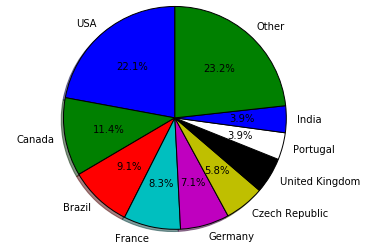

In [30]:
sales = top['total_sales']
labels = top['country']

fig1, ax1 = plt.subplots()
ax1.pie(sales, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

We can see that far and away our biggest categories of sales come from the "USA" and "Other" categories ("Other" being all countries with only one customer). We can ignore the "Other" category for now, as it represents a very broad market and not a unique segment from a marketing perspective. It is good to know, however, how expansive our product has become across the globe. 

The North American market, taken as USA plus Canada, is very promising and makes up 1/3 of all sales in the music library. This is our most profitable market and a good place to focus our marketing efforts in the future, as well as growing our music catalog with artists that appeal to this segment.

PROJECT IS ONGOING.